# Выравнивание слов (Word Alignment)

EM-алгоритм также применяют на практике для настройки параметров модели выравнивания слов, более сложные модификации которой используются в статистическом машинном переводе. Мы не будем подробно обсуждать применение word alignment для перевода. У нас есть параллельный корпус из предложений на исходном языке и их переводов на целевой язык (в этом задании используются английский и чешский соответственно). 

Первая задача — определить с помощью этого корпуса, как переводится каждое отдельное слово на целевом языке. Вторая задача — для произвольной пары из предложения и его перевода установить, переводом какого слова в исходном предложении является каждое слово в целевом предложении. Оказывается, у обеих задач существует элегантное и эффективное решение при введении правильной вероятностной модели: в этой части задания вам предстоит его реализовать и оценить результаты работы. Но обо всём по порядку :)

In [1]:
%%bash
wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1804/CzEnAli_1.0.tar.gz -O CzEnAli_1.0.tar.gz
mkdir -p data
tar -xzf CzEnAli_1.0.tar.gz -C data/
head -n 20 data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa

<?xml version="1.0" encoding="utf-8" ?>
<sentences>
<s id="project_syndicate_bacchetta1-s1">
  <english>Are the Dollar 's Days Numbered ?</english>
  <czech>Jsou dny dolaru sečteny ?</czech>
  <sure>1-1 3-3 5-2 6-4 7-5</sure>
  <possible>2-2 4-3</possible>
</s>
<s id="project_syndicate_bacchetta1-s2">
  <english>Philippe Bacchetta and Eric van Wincoop</english>
  <czech>Philippe Bacchetta and Eric van Wincoop</czech>
  <sure>1-1 2-2 3-3 4-4 5-5 6-6</sure>
  <possible></possible>
</s>
<s id="project_syndicate_bacchetta1-s3">
  <english>A year ago , the dollar bestrode the world like a colossus .</english>
  <czech>Ještě před rokem dolar dominoval světu jako imperátor .</czech>
  <sure>10-7 12-8 13-9 2-3 3-2 6-4 7-5 9-6</sure>
  <possible>1-3 11-8 3-1 5-4 8-6</possible>
</s>


**[Задача А на Yandex Contest](https://contest.yandex.ru/contest/46988/run-report/85219164/)**

In [2]:
import glob
from preprocessing import extract_sentences

all_sentences = []
all_targets = []

for path in glob.glob('data/*/*/*.wa'):
    a, b = extract_sentences(path)
    all_sentences += a
    all_targets += b

**[Задача С на Yandex Contest](https://contest.yandex.ru/contest/46988/run-report/85221828/)**

In [3]:
from preprocessing import get_token_to_index, tokenize_sents

t_idx_src, t_idx_tgt = get_token_to_index(all_sentences)
tokenized_sentences = tokenize_sents(all_sentences, t_idx_src, t_idx_tgt)

В качестве бейзлайна для этой задачи мы возьмём способ выравнивания слов по коэффициенту Дайса: слово в исходном языке является переводом слова на целевом языке, если они часто встречаются в одних и тех же предложениях и редко встречаются по отдельности. 

Математически это записывается по аналогии с мерой Жаккара: пусть $c(x,y)$ — число параллельных предложений, в которых есть и $x$ (на исходном языке), и $y$ (на целевом языке), а $c(x)$ и $c(y)$ — суммарное количество предложений, в которых встречается слово $x$ и $y$ соответственно. Тогда $\textrm{Dice}(x,y)=\frac{2 \cdot c(x,y)}{c(x) + c(y)}$ — характеристика «похожести» слов $x$ и $y$. Она равна 1, если слова встречаются только в контексте друг друга (не бывает предложений только со словом $x$ без $y$ в переводе и наоборот), равна 0, если слова никогда не встречаются в параллельных предложениях и находится между пороговыми значениями в остальных случаях.

В файле `models.py` описан абстрактный класс `BaseAligner`, наследником которого должны являться все модели в задании, а также приведён пример реализации `DiceAligner` выравнивания слов описанным выше путём. Ниже вы можете увидеть, как применять эту модель.

In [4]:
from models import DiceAligner

baseline = DiceAligner(len(t_idx_src), len(t_idx_tgt), threshold=0.01)
baseline.fit(tokenized_sentences)

Чтобы оценить качество модели выравнивания, пользуясь имеющейся разметкой, существует ряд автоматических метрик. Они подразумевают, что в разметке есть два вида выравниваний — «уверенные» (sure) и «возможные» (possible). Обозначим для конкретного предложения первое множество выравниваний $S$, второе — $P$, а предсказанные выравнивания — $A$; причём, в отличие от разметки в файле, $S\subseteq P$. Тогда можно предложить три метрики, используя только операции над этими множествами:

Precision $=\frac{|A\cap P|}{|A|}$. Отражает, какая доля предсказанных нами выравниваний вообще корректна; если мы дадим в качестве ответа все возможные пары слов в предложении, эта метрика сильно просядет.

Recall $=\frac{|A\cap S|}{|S|}$. Эта метрика показывает, какую долю «уверенных» выравниваний мы обнаружили. Если мы попытаемся сделать слишком консервативную модель, которая выдаёт 0 или 1 предсказание на нетривиальных предложениях, полнота получится крайне низкая. 

Alignment Error Rate (AER) $=1-\frac{|A\cap P|+|A\cap S|}{|A|+|S|}$. Метрика является комбинацией двух предыдущих и отслеживает общее качество работы системы, штрафуя оба описанных выше вида нежелаемого поведения модели. 

**[Задача B на Yandex Contest](https://contest.yandex.ru/contest/46988/run-report/85288320/)**

In [5]:
from metrics import compute_aer

compute_aer(all_targets,baseline.align(tokenized_sentences))

0.8115275584918071

Теперь мы можем перейти к базовой вероятностной модели для выравнивания слов. Пусть $S=(s_1,\ldots,s_n)$ исходное предложение, $T=(t_1,\ldots,t_m)$ — его перевод. В роли латентных переменных будут выступать выравнивания $A=(a_1,\ldots,a_m)$ каждого слова в целевом предложении, причём $a_i\in\{1,\ldots,n\}$ (считаем, что каждое слово в $T$ является переводом какого-то слова из $S$). Параметрами модели является матрица условных вероятностей перевода: каждый её элемент $\theta(y|x)=p(y|x)$ отражает вероятность того, что переводом слова $x$ с исходного языка на целевой является слово $y$ (нормировка, соответственно, совершается по словарю целевого языка). Правдоподобие латентных переменных и предложения на целевом языке в этой модели записывается так:

$$
p(A,T|S)=\prod_{i=1}^m p(a_i)p(t_i|a_i,S)=\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i}).
$$ 

**Обозначения (по условию).**
- $S=(s_1,\ldots,s_n)$ --- токены предложения на английском
- $T=(t_1,\ldots,t_m)$ --- токены предложения на чешском
- $A=(a_1,\ldots,a_m)$ --- переводы отдельных слов, т.е. $t_i\sim s_{a_i}$ (выступает в роли латентных переменных EM-алгоритма)

**Дано (по условию).**
- $p(a_i)=1/n, i=\overline{1,m}$ --- априорное распределение латентных переменных
- Пусть $M$ --- мощность корпуса слов на чешском, $N$ --- на английском.
- $\theta\in\mathbb{R}^{M\times N}$ --- параметры вероятностной модели, имеющие следующий смысл: $p(t_i\,|\,a_i,S)=\theta(t_i,s_{a_i}), i=\overline{1,m}$

**Правдоподобие выборки.**
Правдоподобие того, что пара $T,S$ имеет выравнивание слов $A$:
$$
p(A,T\,|\,S)=\prod_{i=1}^m p(a_i,t_i\,|\,S).
$$
Каждый сомножитель распишем по формуле условной вероятности $p(X,Y)=p(X)\cdot P(Y\,|\,X)$ и получим
$$
p(A,T\,|\,S)=\prod_{i=1}^m p(a_i)p(t_i\,|\,a_i,S)
$$

**Апостериорное распределение латентных переменных.**
Имея априорное распределение $p(a_i)$ и условное распределение $p(t_i\,|\,a_i,S)$ получим апостериорное распределение по формуле Байеса:
$$
q_i(j)=p(a_i=j\,|\,t_i,S)={p(a_i=j)p(t_i\,|\,a_i=j,S)\over\sum_{k=1}^np(a_i=k)p(t_i\,|\,a_i=k,S)}, \quad i=\overline{1,m}, j=\overline{1,n}.
$$
Поскольку
- априорное распределение таково, что $p(a_i=j)=1/n, i=\overline{1,m}, j=\overline{1,n}$
- фигурирующие вероятности являются параметрами модели,

то финальная формула:
$$
q_i(j)={\theta(t_i,j)\over\sum_{k=1}^n\theta(t_i,k)}, \quad i=\overline{1,m}, j=\overline{1,n}.
$$


**Е-шаг.**
Посчитаем мат. ожидание логарифма правдоподобия (на одной паре предложений):
$$
\mathbb{E}_q[\log p(A,T\,|\,S)]=\sum_{i=1}^m\mathbb{E}_q[\log p(t_i\,|\,a_i,S)]+\underbrace{\sum_{i=1}^m\mathbb{E}_q[\log p(a_i)]}_{\text{const}}=\\
=\sum_{i=1}^m\sum_{j=1}^n q_i(j)\log p(t_i\,|\,j,S)+\text{const}=\sum_{i=1}^m\sum_{j=1}^n q_i(j)\log \theta(t_i,s_{j})+\text{const}.
$$

Правдоподобие всего корпуса есть произведение правдоподобий каждой тройки $A,T,S$:
$$
L=\prod_{k=1}^Rp(A_k,T_k\,|\,S_k).
$$

Поэтому чтобы получить логарифм правдоподобия всего корпуса нужно просуммировать логарифмы правдоподобия каждой тройки $A,T,S$:
$$
\mathbb{E}_q[\log L]=\sum_{k=1}^R\sum_{i=1}^m\sum_{j=1}^n q_i^k(j)\log \theta(t^k_i,s^k_{j})+\text{const}.
$$




**Нижняя оценка.** 
По утверждению с семинара:
$$
\mathbb{E}_q[\log L]\geqslant\mathcal{L}=\sum_{i,j,k}q_i^k(j)\log{\theta(t_i^k, s_j^k)\over q_i^k(j)m^k}.
$$

**M-шаг.**
Имеем задачу условной оптимизации:
$$
\begin{align}
\min_\theta\ & -\sum_{i,j,k} q_i^k(j)\log \theta(t^k_i,s^k_{j}), \\
\text{s.t.} & \sum_x\theta(x,y)=1,\forall y.
\end{align}
$$
Условие $\theta(x,y)\geqslant0,\forall x,y$ опущено, т.к. решение по совпадению будет ему удовлетворять :)

Лагранжиан задачи:
$$
L=-\sum_{i,j,k} q_i^k(j)\log \theta(t^k_i,s^k_{j})+\sum_y\lambda_y\left(\sum_x\theta(x,y)-1\right).
$$

Условия ККТ:
$$
{\partial L\over\partial\theta(x,y)}=0,\ \forall x,y,\\
\sum_x\theta(x,y)=1,\ \forall y
$$

Из первого уравнения выразим $\theta(x,y)$:
$$
{\partial L\over\partial\theta(x,y)} = -{1\over\theta(x,y)}\sum_{i,j,k}q_i(j)[t_i^k=x][s_j^k=y]+\lambda_y=0\Rightarrow \theta(x,y)=-{1\over\lambda_y}\sum_{i,j,k}q_i^k(j)[t_i^k=x][s_j^k=y].
$$

Подставим это во второе уравнение:
$$
\sum_y\theta(x,y)=1 \iff -{1\over\lambda_y}\sum_{i,j,k}q_i^k(j)[s_j^k=y]\sum_x[t_i^k=x]=1.
$$
Токен $t_i^k$ содержится в словаре в единственном экземпляре (обратное не имеет смысла). Это означает, что $t_i^k$ совпадает только с одним $x$, т.е. $\sum_x[t_i^k=x]=1,\forall i,k$. Получили выражение для множителей Лагранжа:
$$
\lambda_y=-\sum_{i,j,k}q_i^k(j)[s_j^k=y],\quad\forall y.
$$

Ответ:
$$
\theta(x,y)={\sum_{i,j,k}q_i^k(j)[t_i^k=x][s_j^k=y]\over\sum_{i,j,k}q_i^k(j)[s_j^k=y]},\quad\forall x,y.
$$


**Эффективная реализация M-шага.** Величины $q_i^k(j)$ хранятся в виде списка длины $R$ матриц $m\times n$. При этом пара $x,y$ встречается в корпусе как правило не один раз. Поэтому один из способов реализовать формулу для $\theta(x,y)$:
- "накопить" числитель, пробежав по всем парам в параллельном корпусе и сохранив все в матрицу $\theta$,
- нормализовать каждый столбец матрицы $\theta$.

**[Посылка на Yandex Contest](https://contest.yandex.ru/contest/46988/run-report/85331718/)**

In [6]:
from models import WordAligner

word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 20)
word_aligner.fit(tokenized_sentences)

compute_aer(all_targets, word_aligner.align(tokenized_sentences))

0.5803320764064737

Заметим, что таблицу вероятностей перевода можно использовать и саму по себе для построения словарей. Пример работы показан ниже: метод хоть и работает, но мягко говоря, неидально — слишком мало данных.

In [7]:
idx_token_tgt = {index:token for token, index in t_idx_tgt.items()}

In [8]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mr']].argsort()[-3:]]

['Pan', 'řekl', 'pan']

In [9]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mrs']].argsort()[-3:]]

['-', 'Mannová', 'paní']

In [10]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['water']].argsort()[-3:]]

['z', 'pro', 'vody']

In [11]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['depended']].argsort()[-3:]]

['S', 'konec', 'dne']

In [12]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['on']].argsort()[-3:]]

['.', 'se', 'na']

По формуле Байеса:
$$
p(x\,|\,y)=\theta(x,y)\Rightarrow p(y\,|\,x)={p(x\,|\,y)p(y)\over p(x)},
$$
где вероятности $p(x),p(y)$ оценим по корпусу.

In [14]:
import numpy as np

y = np.zeros(len(t_idx_src))
x = np.zeros(len(t_idx_tgt))

for pair in tokenized_sentences:
    np.add.at(y, pair.source_tokens, 1)
    np.add.at(x, pair.target_tokens, 1)

y /= y.sum()
x /= x.sum()

reverse = (word_aligner.translation_probs.T * y) / x[:, None]

dic = {index: token for token, index in t_idx_src.items()}

In [15]:
def ch_to_eng(cz, k=3):
    top_k = reverse[t_idx_tgt[cz]].argsort()[-k:][::-1]
    return [dic[i] for i in top_k]

In [16]:
ch_to_eng('povinni')

['issued', 'instructions', 'observed']

In [17]:
ch_to_eng('média')

['objects', 'Reports', 'reproducing']

In [18]:
ch_to_eng('361')

['Standing', '68', '361']

In [19]:
ch_to_eng('traktorů')

['km', 'machinery', 'bodywork']

#### Предложение 0

In [20]:
alignments = word_aligner.align(tokenized_sentences)
posteriors = word_aligner._e_step(tokenized_sentences)

# sentence index
i = 0

# eng tokens
y = all_sentences[i].source

# chezh tokens
x = all_sentences[i].target

# chezh (vertical) vs english (horozintal)
aligns = np.array(alignments[i]).T - 1

# make heatmap of correspondence
corr = np.zeros((len(y), len(x)), dtype=bool)
corr[aligns[0], aligns[1]] = 1

In [21]:
import matplotlib.pyplot as plt

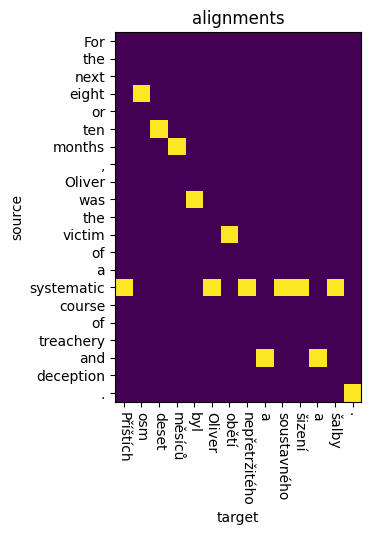

In [22]:
plt.imshow(corr, aspect='equal')

plt.title('alignments')

plt.xlabel('target')
plt.ylabel('source')

plt.yticks(ticks=np.arange(len(y)), labels=y)
_ = plt.xticks(ticks=np.arange(len(x)), labels=x, rotation=-90)

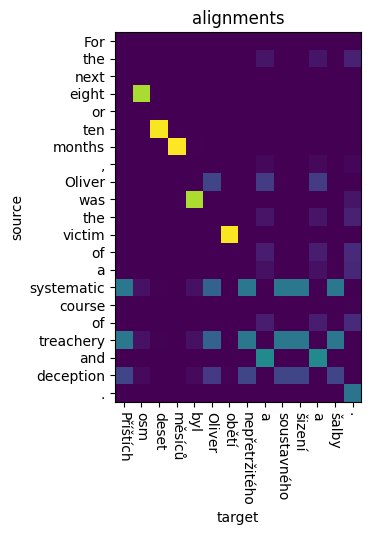

In [23]:
plt.imshow(posteriors[i], aspect='equal')

plt.title('alignments')

plt.xlabel('target')
plt.ylabel('source')

plt.yticks(ticks=np.arange(len(y)), labels=y)
_ = plt.xticks(ticks=np.arange(len(x)), labels=x, rotation=-90)

#### Предложение 10

In [24]:
alignments = word_aligner.align(tokenized_sentences)
posteriors = word_aligner._e_step(tokenized_sentences)

# sentence index
i = 10

# eng tokens
y = all_sentences[i].source

# chezh tokens
x = all_sentences[i].target

# chezh (vertical) vs english (horozintal)
aligns = np.array(alignments[i]).T - 1

# make heatmap of correspondence
corr = np.zeros((len(y), len(x)), dtype=bool)
corr[aligns[0], aligns[1]] = 1

In [25]:
import matplotlib.pyplot as plt

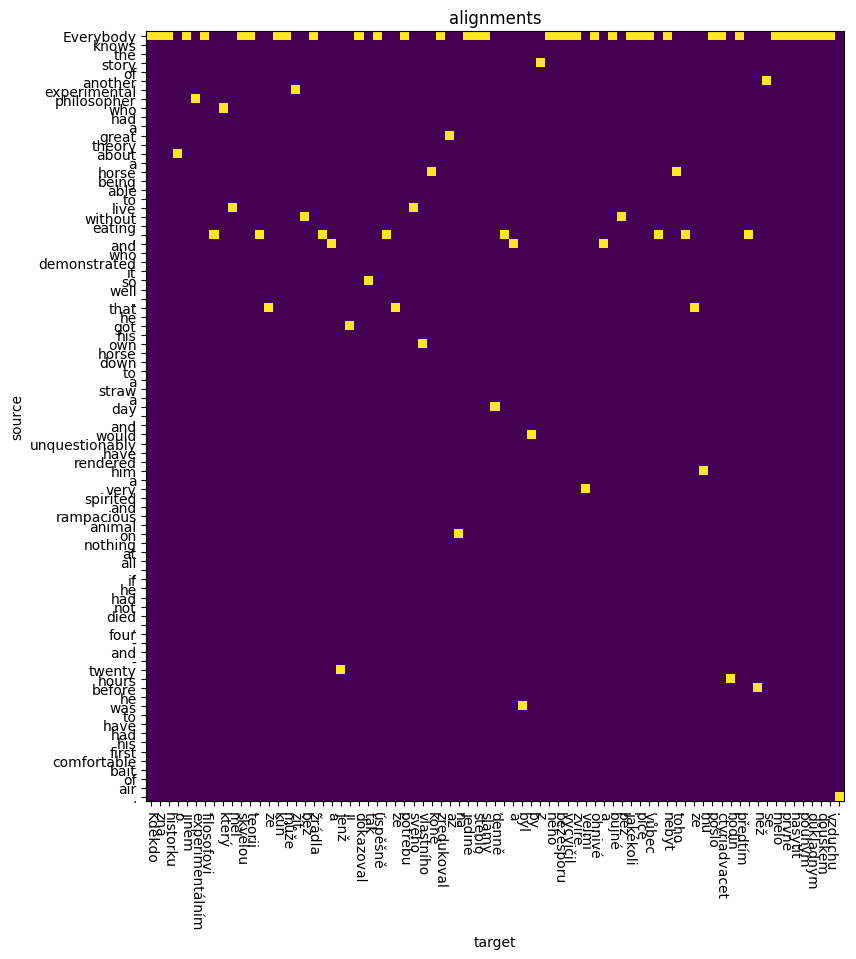

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(corr, aspect='equal')

plt.title('alignments')

plt.xlabel('target')
plt.ylabel('source')

plt.yticks(ticks=np.arange(len(y)), labels=y)
_ = plt.xticks(ticks=np.arange(len(x)), labels=x, rotation=-90)

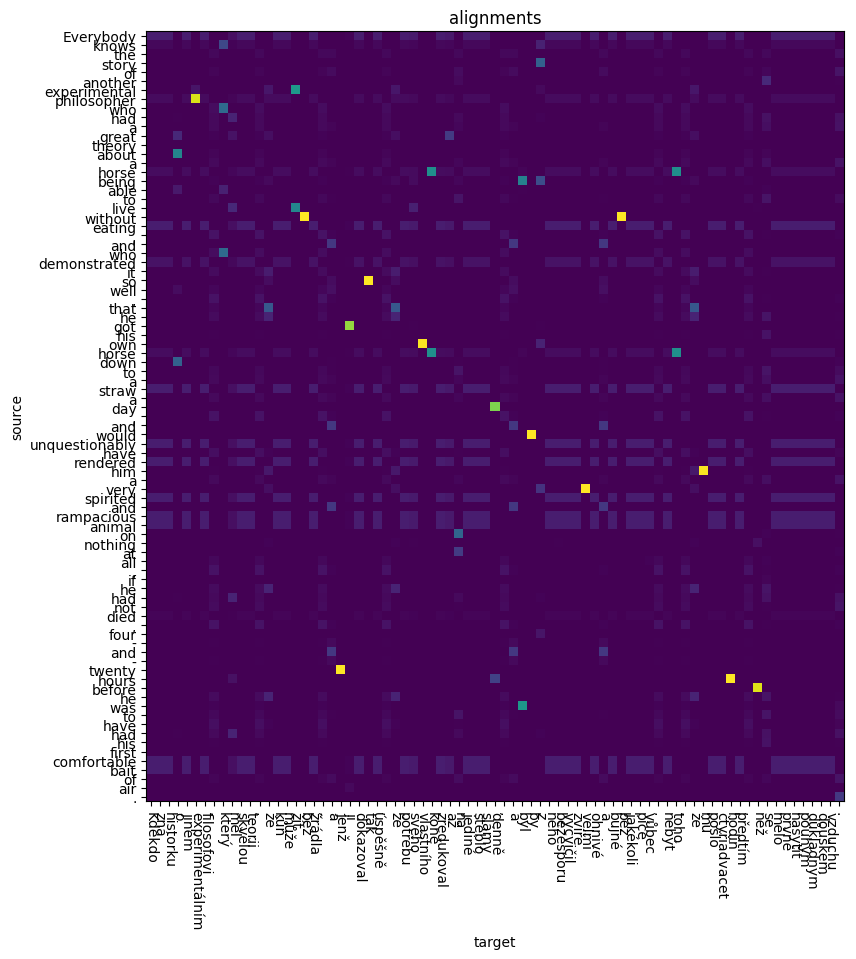

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(posteriors[i], aspect='equal')

plt.title('alignments')

plt.xlabel('target')
plt.ylabel('source')

plt.yticks(ticks=np.arange(len(y)), labels=y)
_ = plt.xticks(ticks=np.arange(len(x)), labels=x, rotation=-90)

#### Предложение 20

In [30]:
alignments = word_aligner.align(tokenized_sentences)
posteriors = word_aligner._e_step(tokenized_sentences)

# sentence index
i = 20

# eng tokens
y = all_sentences[i].source

# chezh tokens
x = all_sentences[i].target

# chezh (vertical) vs english (horozintal)
aligns = np.array(alignments[i]).T - 1

# make heatmap of correspondence
corr = np.zeros((len(y), len(x)), dtype=bool)
corr[aligns[0], aligns[1]] = 1

In [31]:
import matplotlib.pyplot as plt

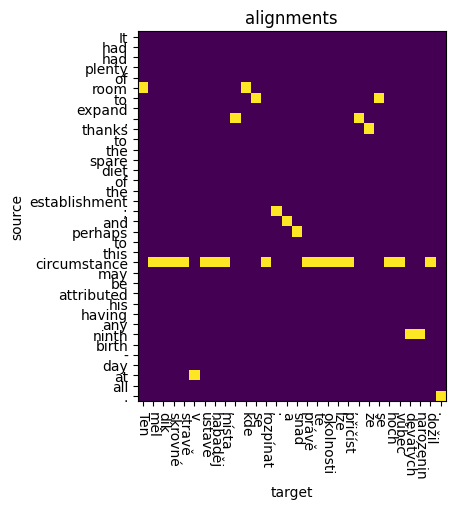

In [32]:
plt.imshow(corr, aspect='equal')

plt.title('alignments')

plt.xlabel('target')
plt.ylabel('source')

plt.yticks(ticks=np.arange(len(y)), labels=y)
_ = plt.xticks(ticks=np.arange(len(x)), labels=x, rotation=-90)

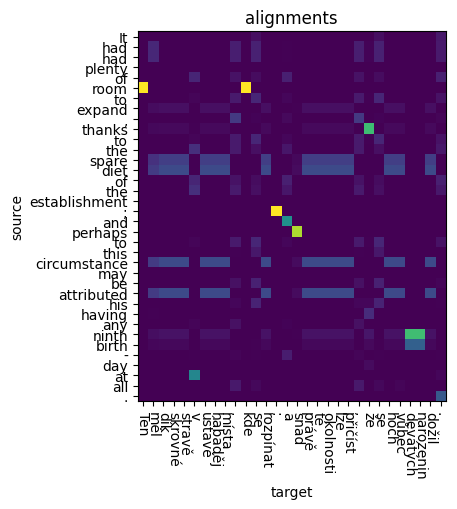

In [33]:
plt.imshow(posteriors[i], aspect='equal')

plt.title('alignments')

plt.xlabel('target')
plt.ylabel('source')

plt.yticks(ticks=np.arange(len(y)), labels=y)
_ = plt.xticks(ticks=np.arange(len(x)), labels=x, rotation=-90)

#### Предложение 30

In [34]:
alignments = word_aligner.align(tokenized_sentences)
posteriors = word_aligner._e_step(tokenized_sentences)

# sentence index
i = 30

# eng tokens
y = all_sentences[i].source

# chezh tokens
x = all_sentences[i].target

# chezh (vertical) vs english (horozintal)
aligns = np.array(alignments[i]).T - 1

# make heatmap of correspondence
corr = np.zeros((len(y), len(x)), dtype=bool)
corr[aligns[0], aligns[1]] = 1

In [35]:
import matplotlib.pyplot as plt

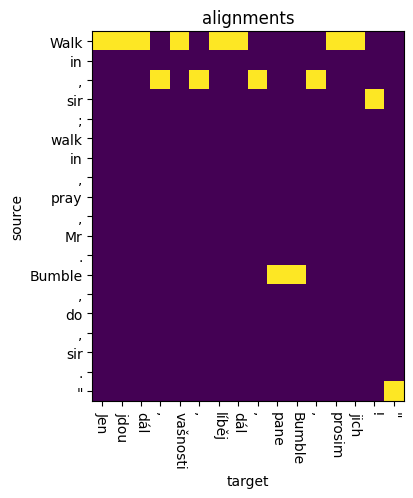

In [36]:
plt.imshow(corr, aspect='equal')

plt.title('alignments')

plt.xlabel('target')
plt.ylabel('source')

plt.yticks(ticks=np.arange(len(y)), labels=y)
_ = plt.xticks(ticks=np.arange(len(x)), labels=x, rotation=-90)

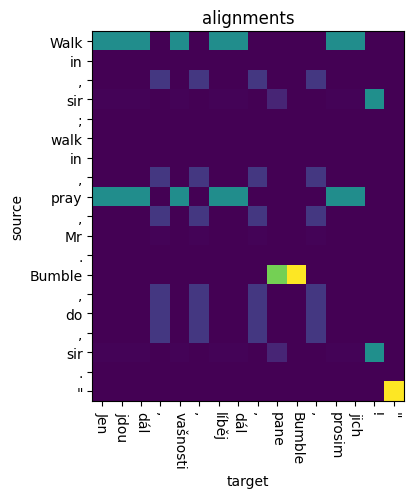

In [37]:
plt.imshow(posteriors[i], aspect='equal')

plt.title('alignments')

plt.xlabel('target')
plt.ylabel('source')

plt.yticks(ticks=np.arange(len(y)), labels=y)
_ = plt.xticks(ticks=np.arange(len(x)), labels=x, rotation=-90)

Модель хорошо справляется с частыми словами, плохо -- с запятыми (предложение 0) и редкими словами (предложение 30: фамилии русских деятелей искусства серебряного века). Ну и логично что слова в переводе следуют в том же порядке что и в оригинале.